# TD Deep Q-Network

# Tutorial - Deep Q-Learning 

Deep Q-Learning uses a neural network to approximate $Q$ functions. Hence, we usually refer to this algorithm as DQN (for *deep Q network*).

The parameters of the neural network are denoted by $\theta$. 
*   As input, the network takes a state $s$,
*   As output, the network returns $Q_\theta [a | s] = Q_\theta (s,a) = Q(s, a, \theta)$, the value of each action $a$ in state $s$, according to the parameters $\theta$.


The goal of Deep Q-Learning is to learn the parameters $\theta$ so that $Q(s, a, \theta)$ approximates well the optimal $Q$-function $Q^*(s, a) \simeq Q_{\theta^*} (s,a)$. 

In addition to the network with parameters $\theta$, the algorithm keeps another network with the same architecture and parameters $\theta^-$, called **target network**.

The algorithm works as follows:

1.   At each time $t$, the agent is in state $s_t$ and has observed the transitions $(s_i, a_i, r_i, s_i')_{i=1}^{t-1}$, which are stored in a **replay buffer**.

2.  Choose action $a_t = \arg\max_a Q_\theta(s_t, a)$ with probability $1-\varepsilon_t$, and $a_t$=random action with probability $\varepsilon_t$. 

3. Take action $a_t$, observe reward $r_t$ and next state $s_t'$.

4. Add transition $(s_t, a_t, r_t, s_t')$ to the **replay buffer**.

4.  Sample a minibatch $\mathcal{B}$ containing $B$ transitions from the replay buffer. Using this minibatch, we define the loss:

$$
L(\theta) = \sum_{(s_i, a_i, r_i, s_i') \in \mathcal{B}}
\left[
Q(s_i, a_i, \theta) -  y_i
\right]^2
$$
where the $y_i$ are the **targets** computed with the **target network** $\theta^-$:

$$
y_i = r_i + \gamma \max_{a'} Q(s_i', a', \theta^-).
$$

5. Update the parameters $\theta$ to minimize the loss, e.g., with gradient descent (**keeping $\theta^-$ fixed**): 
$$
\theta \gets \theta - \eta \nabla_\theta L(\theta)
$$
where $\eta$ is the optimization learning rate. 

6. Every $N$ transitions ($t\mod N$ = 0), update target parameters: $\theta^- \gets \theta$.

7. $t \gets t+1$. Stop if $t = T$, otherwise go to step 2.

In [57]:
# Imports
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from copy import deepcopy
import gym
from gym.wrappers import Monitor

# from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output
from pathlib import Path
import base64

In [58]:
print(f"python --version = {sys.version}")
print(f"torch.__version__ = {torch.__version__}")
print(f"np.__version__ = {np.__version__}")
print(f"gym.__version__ = {gym.__version__}")

python --version = 3.8.10 (v3.8.10:3d8993a744, May  3 2021, 09:09:08) 
[Clang 12.0.5 (clang-1205.0.22.9)]
torch.__version__ = 1.10.1
np.__version__ = 1.21.4
gym.__version__ = 0.21.0


## Torch 101

>"The torch package contains data structures for multi-dimensional tensors and defines mathematical operations over these tensors. Additionally, it provides many utilities for efficient serializing of Tensors and arbitrary types, and other useful utilities. 
[...] provides classes and functions implementing automatic differentiation of arbitrary scalar valued functions." 
[PyTorch](https://pytorch.org/docs/stable/index.html)


### Variable types

In [59]:
# Very similar syntax to numpy.
zero_torch = torch.zeros((3, 2))

print('zero_torch is of type {:s}'.format(str(type(zero_torch))))

# Torch -> Numpy: simply call the numpy() method.
zero_np = np.zeros((3, 2))
assert (zero_torch.numpy() == zero_np).all()

# Numpy -> Torch: simply call the corresponding function on the np.array.
zero_torch_float = torch.FloatTensor(zero_np)
print('\nFloat:\n', zero_torch_float)
zero_torch_int = torch.LongTensor(zero_np)
print('Int:\n', zero_torch_int)
zero_torch_bool = torch.BoolTensor(zero_np)
print('Bool:\n', zero_torch_bool)

# Reshape
print('\nView new shape...', zero_torch.view(1, 6))
# Note that print(zero_torch.reshape(1, 6)) would work too.
# The difference is in how memory is handled (view imposes contiguity).

# Algebra
a = torch.randn((3, 2))
b = torch.randn((3, 2))
print('\nAlgebraic operations are overloaded:\n', a, '\n+\n', b, '\n=\n', a+b )

# More generally, torch shares the syntax of many attributes and functions with Numpy.

zero_torch is of type <class 'torch.Tensor'>

Float:
 tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])
Int:
 tensor([[0, 0],
        [0, 0],
        [0, 0]])
Bool:
 tensor([[False, False],
        [False, False],
        [False, False]])

View new shape... tensor([[0., 0., 0., 0., 0., 0.]])

Algebraic operations are overloaded:
 tensor([[ 0.3009,  1.4382],
        [-0.9523,  0.0252],
        [-0.9045,  0.8632]]) 
+
 tensor([[ 1.2569,  0.5458],
        [ 0.3136,  0.6893],
        [-0.9142,  1.6274]]) 
=
 tensor([[ 1.5578,  1.9840],
        [-0.6387,  0.7145],
        [-1.8186,  2.4906]])


### Gradient management

In [60]:
# torch.Tensor is a similar yet more complicated data structure than np.array.
# It is basically a static array of number but may also contain an overlay to 
# handle automatic differentiation (i.e keeping track of the gradient and which 
# tensors depend on which).
# To access the static array embedded in a tensor, simply call the detach() method
print(zero_torch.detach())

# When inside a function performing automatic differentiation (basically when training 
# a neural network), never use detach() otherwise meta information regarding gradients
# will be lost, effectively freezing the variable and preventing backprop for it. 
# However when returning the result of training, do use detach() to save memory 
# (the naked tensor data uses much less memory than the full-blown tensor with gradient
# management, and is much less prone to mistake such as bad copy and memory leak).

# We will solve theta * x = y in theta for x=1 and y=2
x = torch.ones(1)
y = 2 * torch.ones(1)

# Actually by default torch does not add the gradient management overlay
# when declaring tensors like this. To force it, add requires_grad=True.
theta = torch.randn(1, requires_grad=True)

# Optimisation routine
# (Adam is a sophisticated variant of SGD, with adaptive step).
optimizer = optim.Adam(params=[theta], lr=0.1)

# Loss function
print('Initial guess:', theta.detach())

for _ in range(100):
    # By default, torch accumulates gradients in memory.
    # To obtain the desired gradient descent beahviour,
    # just clean the cached gradients using the following line:
    optimizer.zero_grad()
    
    # Quadratic loss (* and ** are overloaded so that torch
    # knows how to differentiate them)
    loss = (y - theta * x) ** 2
    
    # Apply the chain rule to automatically compute gradients
    # for all relevant tensors.
    loss.backward()
    
    # Run one step of optimisation routine.
    optimizer.step()
    
print('Final estimate:', theta.detach())
print('The final estimate should be close to', y)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])
Initial guess: tensor([-0.8437])
Final estimate: tensor([1.9852])
The final estimate should be close to tensor([2.])


## Setting the environment

### 1 - Define the GLOBAL parameters

In [61]:
# Environment
env = gym.make("CartPole-v0")

# Discount factor
GAMMA = 0.99

# Batch size
BATCH_SIZE = 256
# Capacity of the replay buffer
BUFFER_CAPACITY = 16384 # 10000
# Update target net every ... episodes
UPDATE_TARGET_EVERY = 32 # 20

# Initial value of epsilon
EPSILON_START = 1.0
# Parameter to decrease epsilon
DECREASE_EPSILON = 100
# Minimum value of epislon
EPSILON_MIN = 0.05

# Number of training episodes
N_EPISODES = 1000

# Learning rate
LEARNING_RATE = 0.1

### 2 - Replay buffer

In [62]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, reward, next_state):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, reward, next_state)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.choices(self.memory, k=batch_size)

    def __len__(self):
        return len(self.memory)

# create instance of replay buffer
replay_buffer = ReplayBuffer(BUFFER_CAPACITY)

### 3 - Neural Network

In [63]:
class Net(nn.Module):
    """
    Basic neural net.
    """
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        return self.net(x)

### 3.5 - Loss function and optimizer

In [64]:
# create network and target network
hidden_size = 128
obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n

q_net = Net(obs_size, hidden_size, n_actions)
target_net = Net(obs_size, hidden_size, n_actions)

# objective and optimizer
objective = nn.MSELoss()
optimizer = optim.Adam(params=q_net.parameters(), lr=LEARNING_RATE)

### Question 0 (to do at home, not during the live session)

With your own word, explain the intuition behind DQN. Recall the main parts of the aformentionned algorithm.

A DQN, or Deep Q-Network, approximates a state-value function in a Q-Learning framework with a neural network. In the Atari Games case, they take in several frames of the game as an input and output state values for each action as an output.

It is usually used in conjunction with Experience Replay, for storing the episode steps in memory for off-policy learning, where samples are drawn from the replay memory at random. Additionally, the Q-Network is usually optimized towards a frozen target network that is periodically updated with the latest weights every
steps (where is a hyperparameter). The latter makes training more stable by preventing short-term oscillations from a moving target. The former tackles autocorrelation that would occur from on-line learning, and having a replay memory makes the problem more like a supervised learning problem.


On se place dans une suite d'états s avec des actions a  
L'objectif est à partir d'un état s exécuter l'action a qui amène à l'état s' qui à valeur maximale  
Q prédit la valeur du couple (s,a) c'est à dire de l'état s'' qui pourrait être obtenu en faisant l'action a en s  
A partir de Q on détermine la meilleure action à faire  
Une fois l'état s' obtenu on ajuste Q suivant la formule du cours Q(s,a) = (1-aplha).Q(s,a) + alpha. (r+gamma.max_a'Q(s',a'))  
On modélise Q avec un réseau de neurones pour palier au problème du grand nombre d'états (continu)  


Réference: https://paperswithcode.com/method/dqn  
https://github.com/gle-bellier/dueling-network-architectures/blob/8519a0932d6e55d0f5cf40dd841ad11dbc7edad5/notebooks/Deep_Q_Learning.ipynb
https://github.com/amathsow/machine-learning/blob/master/DQN.ipynb  
https://github.com/Volviane/Reinforcement-learning/blob/master/Practical_Session_DQN.ipynb  


## Implementing the DQN

In [65]:
def get_q(states):
    """
    Compute Q function for a list of states
    """
    with torch.no_grad():
        states_v = torch.FloatTensor(np.array([states]))
        output = q_net.forward(states_v).detach().numpy()  # shape (1, len(states), n_actions)
    return output[0, :, :]  # shape (len(states), n_actions)

#### Question 1

Implement the `choose_action` function.

In [66]:
def choose_action(state, epsilon):
    """
    Return action according to an epsilon-greedy exploration policy
    """  
    actions = get_q([state])[0]    
    n_action = len(actions)    
    exploration = np.random.random()    
    if exploration < epsilon :        
        return np.random.randint(0,n_action)    
    else :        
        return np.argmax(actions)

#### Question 2

Implement the `eval_dqn` function.

In [67]:
def eval_dqn(n_sim=5):
    """
    Monte Carlo evaluation of DQN agent.

    Repeat n_sim times:
        * Run the DQN policy until the environment reaches a terminal state (= one episode)
        * Compute the sum of rewards in this episode
        * Store the sum of rewards in the episode_rewards array.
    """
    env_copy = deepcopy(env)
    episode_rewards = np.zeros(n_sim)
    
    for i in range(n_sim):
        state = env_copy.reset()
        done = False
        while not done:
            action = choose_action(state, 0.0)
            state, reward, done, _ = env_copy.step(action)
            episode_rewards[i] += reward
    return episode_rewards

#### Question 3

Implement the `update` function

In [68]:
def update(state, action, reward, next_state, done):
    """

    """
    # add data to replay buffer
    if done:
        next_state = None
    replay_buffer.push(state, action, reward, next_state)

    if len(replay_buffer) < BATCH_SIZE:
        return np.inf

    # get batch
    transitions = replay_buffer.sample(BATCH_SIZE)

   # 1st thing: compute Q(s_i, a_i, theta) for all (s_i, a_i)
   # in the batch

   # Build tensor with s_i and tensor with a_i
    batch_states = torch.FloatTensor( 
                    [transitions[ii][0] for ii in range(BATCH_SIZE) ]
                    )
    batch_actions = torch.LongTensor(  # type is important (Long) 
                    [ transitions[ii][1] for ii in range(BATCH_SIZE) ]
                    )
    batch_rewards = torch.FloatTensor( 
                    [ transitions[ii][2] for ii in range(BATCH_SIZE) ]
                    )
    
    non_final_mask = torch.tensor([(transitions[ii][3] is not None) 
                                   for ii in range(BATCH_SIZE)], dtype=torch.bool)
    non_final_next_states = torch.FloatTensor(
            [transitions[ii][3]  for ii in range(BATCH_SIZE) 
            if transitions[ii][3] is not None])
        
    next_state_values = torch.zeros(BATCH_SIZE)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    state_action_values = q_net(batch_states).gather(1, batch_actions.view(-1, 1))
    
    # Compute loss - TO BE IMPLEMENTED!
    values  = state_action_values
    targets = batch_rewards + GAMMA*next_state_values
    loss = objective(values, targets.unsqueeze(1))

    # Compute loss - TO BE IMPLEMENTED!
    # states = torch.FloatTensor([trans[0] for trans in transitions])
    # rewards = torch.FloatTensor([trans[2] for trans in transitions])
    # actions = torch.LongTensor([trans[1] for trans in transitions])
    #
    # next_states = torch.FloatTensor([transitions[i][3] for i in range(BATCH_SIZE) if transitions[i][3] is not None]) 

    # mask = [transitions[i][3] is not None for i in range(BATCH_SIZE)]

    # states_q = q_net.forward(states)

    # next_states_q = torch.zeros(BATCH_SIZE)
    # next_states_q[mask] = target_net.forward(next_states).max(dim=1)[0].data 
    # next_states_q = next_states_q.reshape(-1, 1)

    # targets = rewards + GAMMA*next_states_q # to be computed using batch
    
    # values = torch.gather(states_q, dim = 1, index = actions.reshape(-1,1)) 
    
    # loss = objective(values, targets) 
    
    # Optimize the model - UNCOMMENT!
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.detach().numpy()

#### Question 4
Train a DQN on the `env` environment.
*Hint* The mean reward after training should be close to 200.

In [69]:
EVAL_EVERY = 5
REWARD_THRESHOLD = 199

def train():
    state = env.reset()
    epsilon = EPSILON_START
    ep = 0
    total_time = 0
    losses = []
    rewards_ = []
    while ep < N_EPISODES:
        action = choose_action(state, epsilon)

        # take action and update replay buffer and networks
        next_state, reward, done, _ = env.step(action)
        loss = update(state, action, reward, next_state, done)

        # update state
        state = next_state

        # end episode if done
        if done:
            state = env.reset()
            ep   += 1
            if ( (ep+1)% EVAL_EVERY == 0):
                rewards = eval_dqn()
                print("episode =", ep+1, ", reward = ", np.mean(rewards), ", loss = ", loss)
                if np.mean(rewards) >= REWARD_THRESHOLD:
                    break

            # update target network
            if ep % UPDATE_TARGET_EVERY == 0:
                target_net.load_state_dict(q_net.state_dict())
            # decrease epsilon
            epsilon = EPSILON_MIN + (EPSILON_START - EPSILON_MIN) * \
                            np.exp(-1. * ep / DECREASE_EPSILON )    
            losses += [loss]
            rewards_ += [rewards]
            
        total_time += 1
    return losses, rewards_ 

# Run the training loop
losses, rewards_ = train()

# Evaluate the final policy
rewards = eval_dqn(20)
print("")
print("mean reward after training = ", np.mean(rewards))

episode = 5 , reward =  30.4 , loss =  inf
episode = 10 , reward =  28.0 , loss =  inf
episode = 15 , reward =  12.0 , loss =  0.0010938346
episode = 20 , reward =  24.4 , loss =  0.0004410166
episode = 25 , reward =  19.0 , loss =  0.00052026217
episode = 30 , reward =  19.8 , loss =  0.0004373184
episode = 35 , reward =  9.4 , loss =  0.047970887
episode = 40 , reward =  11.0 , loss =  0.03529239
episode = 45 , reward =  9.2 , loss =  0.017626038
episode = 50 , reward =  9.6 , loss =  0.01493181
episode = 55 , reward =  9.6 , loss =  0.0053276615
episode = 60 , reward =  10.2 , loss =  0.010620292
episode = 65 , reward =  18.0 , loss =  0.010024826
episode = 70 , reward =  11.0 , loss =  0.02702087
episode = 75 , reward =  24.4 , loss =  0.026813712
episode = 80 , reward =  9.4 , loss =  0.017693534
episode = 85 , reward =  12.2 , loss =  0.01078002
episode = 90 , reward =  10.2 , loss =  0.021932228
episode = 95 , reward =  10.8 , loss =  0.012967667
episode = 100 , reward =  10.2 ,

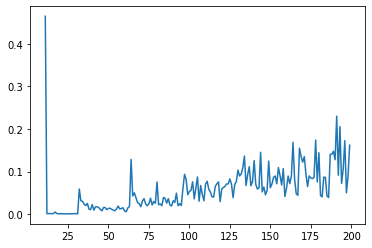

In [ ]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(200)],losses)

#### Question 5

Experiment the policy network.

(Showing a video with a jupyter notebook, you may try this cell with Chrome/Chromium instead of Firefox. Otherwise, you may skip this question.)

In [80]:
def show_video():
    html = []
    for mp4 in Path("videos").glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))
    
env = Monitor(env, './videos', force=True, video_callable=lambda episode: True)

for episode in range(1):
    done = False
    state = env.reset()
    while not done:
        action = choose_action(state, 0.0)
        state, reward, done, info = env.step(action)
env.close()
#show_video()

2022-02-15 12:21:33.658 Python[93185:2355311] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/pj/txbvyslx6zg5hgwg2f3zqm_00000gn/T/org.python.python.savedState


### Experiments: Do It Yourself

Remember the set of global parameters:
```
# Environment
env = gym.make("CartPole-v0")

# Discount factor
GAMMA = 0.99

# Batch size
BATCH_SIZE = 256
# Capacity of the replay buffer
BUFFER_CAPACITY = 16384 # 10000
# Update target net every ... episodes
UPDATE_TARGET_EVERY = 32 # 20

# Initial value of epsilon
EPSILON_START = 1.0
# Parameter to decrease epsilon
DECREASE_EPSILON = 200
# Minimum value of epislon
EPSILON_MIN = 0.05

# Number of training episodes
N_EPISODES = 200

# Learning rate
LEARNING_RATE = 0.1
```

#### Question 6

Craft an experiment and study the influence of the `BUFFER_CAPACITY` on the learning process (speed of *convergence*, training curves...) 

**Answer 6**  
Un buffer trop petit crée beaucoup d'instabilité car seul les dernières parties sont jouées. Une mauvaise partie efface donc toute la mémoire et reset l'apprentissage
Un buffer trop grand prend de la place en mémoire et en temps (sélectionner un batch) tout en étant mauvais car il garde des parties trop vieilles et donc inutiles.


#### Question 7

Craft an experiment and study the influence of the `UPDATE_TARGET_EVERY` on the learning process (speed of *convergence*, training curves...)


***Answer 7**  
Plus UPDATE_TARGET_EVERY moins il faut jouer de parties avant d'actualiser le réseau de neurones.  
Si UPDATE_TARGET_EVERY est trop petit on ne joue pas assez entre chaque actualisation, on actualise donc le réseau sur de vieilles parties ce qui le rend instable car il peut désapprendre.  
Si UPDATE_TARGET_EVERY est trop grand on pert inutilement du temps.  
Comme CartPole est très simple, un UPDATE_TARGET_EVERY de 1 convient ici pour un buffer pas trop grand.  

#### Question 8

If you have the computer power to do so, try to do a grid search on those two hyper-parameters and comment the results. Otherwise, study the influence of another hyper-parameter.

**Answer 8**  
N'ayant pas la puissance de calcul pour réaliser un grid-search j'ai décidé de regarder l'influence de BATCH_SIZE Un BATCH_SIZE influence directement sur le temps d'apprentissage.  
Si BATCH_SIZE est trop petit on risque de jouer trop par rapport à l'apprentissage. BATCH_SIZE doit donc dépendre indirectement de UPDATE_TARGET_EVERY.  
Si BATCH_SIZE est trop grand le temps d'apprentissage et inutilement long. On s'expose aussi à des problèmes de surapprentissage car l'intégralité d'une partie peut se retrouver dans le batch. Le réseau risque alors d'apprendre "par cœur" cette partie au lieu de l'extrapoler ce qui lui est néfaste.  

## Discretization

It is natural to use a function approximator like a neural network to approximate the $Q$ function in a continuous environment. Another natural but unscalable way to do handle continuous state-action space is **discretization**.

Discretize the environment of your choice (cartpole or mountain car or both) and run one of the algorithms that you know to compute an approximation of the optimal $Q$ function.

Once you are satisfied with your results, you may plot the *optimal phase diagram* of the system. For instance, you may get something like this for the mountain car environment.

![Phase diagram](./img/phase_plot.png)

In [81]:
# TODO: Everything! This is an introduction to research and development